In [104]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.base import clone
from sklearn.svm import SVR
from xgboost import XGBRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
trainPath = r"dataset\train.csv"
testPath = r"dataset\test.csv"

trainData = pd.read_csv(trainPath)
testData = pd.read_csv(testPath)

In [3]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [4]:
difference = set(trainData).difference(set(testData))
difference

{'Listening_Time_minutes'}

In [5]:
trainData.Listening_Time_minutes

0          31.41998
1          88.01241
2          44.92531
3          46.27824
4          75.61031
            ...    
749995     56.87058
749996     45.46242
749997     15.26000
749998    100.72939
749999     11.94439
Name: Listening_Time_minutes, Length: 750000, dtype: float64

## **EDA**

In [6]:
num_df = trainData.select_dtypes(include=['float64']).copy()
num_df

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
0,NaN,74.81,NaN,0.0,31.41998
1,119.80,66.95,75.95,2.0,88.01241
2,73.90,69.97,8.97,0.0,44.92531
3,67.17,57.22,78.70,2.0,46.27824
4,110.51,80.07,58.68,3.0,75.61031
...,...,...,...,...,...
749995,75.66,69.36,NaN,0.0,56.87058
749996,75.75,35.21,NaN,2.0,45.46242
749997,30.98,78.58,84.89,0.0,15.26000
749998,108.98,45.39,93.27,0.0,100.72939


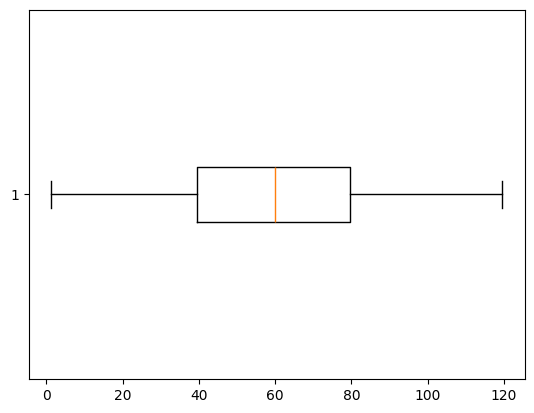

In [7]:
plt.boxplot(num_df.Host_Popularity_percentage, vert=False)
plt.show()

In [8]:
def outliers(df : pd.DataFrame, column_name : str):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column_name] < lower_bound) |
                    (df[column_name] > upper_bound)]

    print("Outliers:")
    print(outliers[[column_name]])


In [9]:
outliers(num_df, "Host_Popularity_percentage")

Outliers:
Empty DataFrame
Columns: [Host_Popularity_percentage]
Index: []


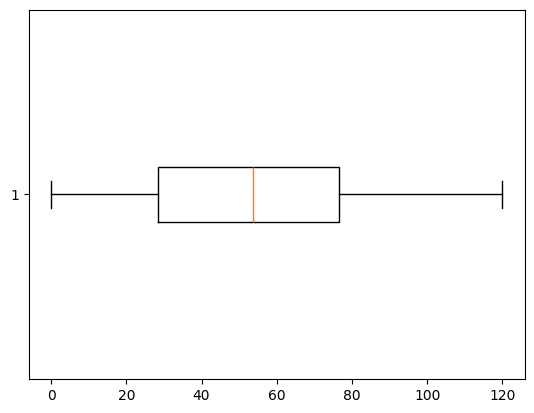

In [10]:
plt.boxplot(num_df.Guest_Popularity_percentage.dropna(), vert=False)
plt.show()

In [11]:
outliers(num_df, "Host_Popularity_percentage")

Outliers:
Empty DataFrame
Columns: [Host_Popularity_percentage]
Index: []


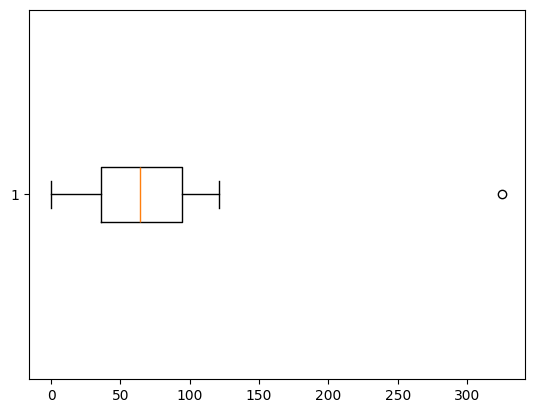

In [12]:
plt.boxplot(num_df.Episode_Length_minutes.dropna(), vert=False)
plt.show()

In [13]:
outliers(num_df, "Episode_Length_minutes")

Outliers:
        Episode_Length_minutes
101637                  325.24


In [14]:
Q1 = num_df["Episode_Length_minutes"].quantile(0.25)
Q3 = num_df["Episode_Length_minutes"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(upper_bound)

181.57999999999998


In [15]:
X = trainData.copy().drop(columns=['Listening_Time_minutes'])
Y = trainData.Listening_Time_minutes

In [16]:
X.loc[101637, "Episode_Length_minutes"] = upper_bound

In [17]:
X.iloc[101637]

id                                    101637
Podcast_Name                   Home & Living
Episode_Title                     Episode 16
Episode_Length_minutes                181.58
Genre                              Lifestyle
Host_Popularity_percentage             50.69
Publication_Day                      Tuesday
Publication_Time                   Afternoon
Guest_Popularity_percentage            15.01
Number_of_Ads                            0.0
Episode_Sentiment                   Positive
Name: 101637, dtype: object

In [18]:
X

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative


In [19]:
X.Episode_Title.value_counts()

Episode_Title
Episode 71    10515
Episode 62    10373
Episode 31    10292
Episode 61     9991
Episode 69     9864
              ...  
Episode 2      5134
Episode 25     5117
Episode 41     4965
Episode 37     4940
Episode 95     4838
Name: count, Length: 100, dtype: int64

In [20]:
X.Genre.value_counts()

Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int64

In [21]:
def draw_pie(series: pd.Series, figsize: tuple = (7.5, 7.5), title : str = None, ax=None):
    values = series.value_counts()
    labels = values.index
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(title)

In [22]:
total_watch_time_day = []
days = []

for i, day in enumerate(X.Publication_Day.unique()):
    watch_time = trainData[trainData["Publication_Day"] == day].Listening_Time_minutes.sum()
    days.append(day)
    total_watch_time_day.append(watch_time)

print(days)
print(total_watch_time_day)

['Thursday', 'Saturday', 'Tuesday', 'Monday', 'Sunday', 'Wednesday', 'Friday']
[np.float64(4682602.46802), np.float64(4691547.82229), np.float64(4525629.84607), np.float64(5146897.66395), np.float64(5196398.045399999), np.float64(4941953.086030001), np.float64(4893025.78434)]


In [23]:
def plot_bar(x, height, title : str = None, y_label : str = None, x_label : str = None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,6))

    bars = ax.bar(x, height, color='royalblue', edgecolor='black')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 30000, f"{height:,.0f}", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x, rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

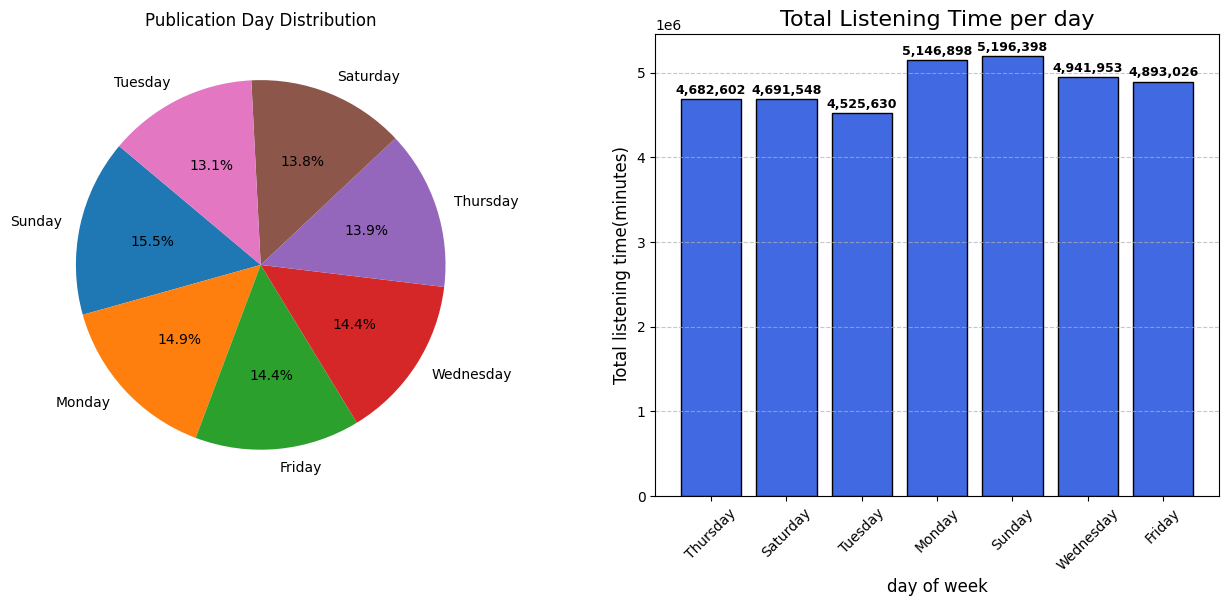

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

draw_pie(X.Publication_Day, title= 'Publication Day Distribution', ax=axes[0])
plot_bar(days, total_watch_time_day, ax = axes[1], title='Total Listening Time per day', x_label= 'day of week', y_label='Total listening time(minutes)')

The greater watch time for Sunday and Monday could be equated to either Sunday being a holiday or could be the cause of more podcasts being released on these days as compared to others

In [25]:
total_watch_time_phase = []
phases = []

for i, phase in enumerate(X.Publication_Time.unique()):
    watch_time = trainData[trainData["Publication_Time"] == phase].Listening_Time_minutes.sum()
    phases.append(phase)
    total_watch_time_phase.append(watch_time)

print(phases)
print(total_watch_time_phase)

['Night', 'Afternoon', 'Evening', 'Morning']
[np.float64(9144946.01335), np.float64(8170024.80079), np.float64(8763329.978050001), np.float64(7999753.923909999)]


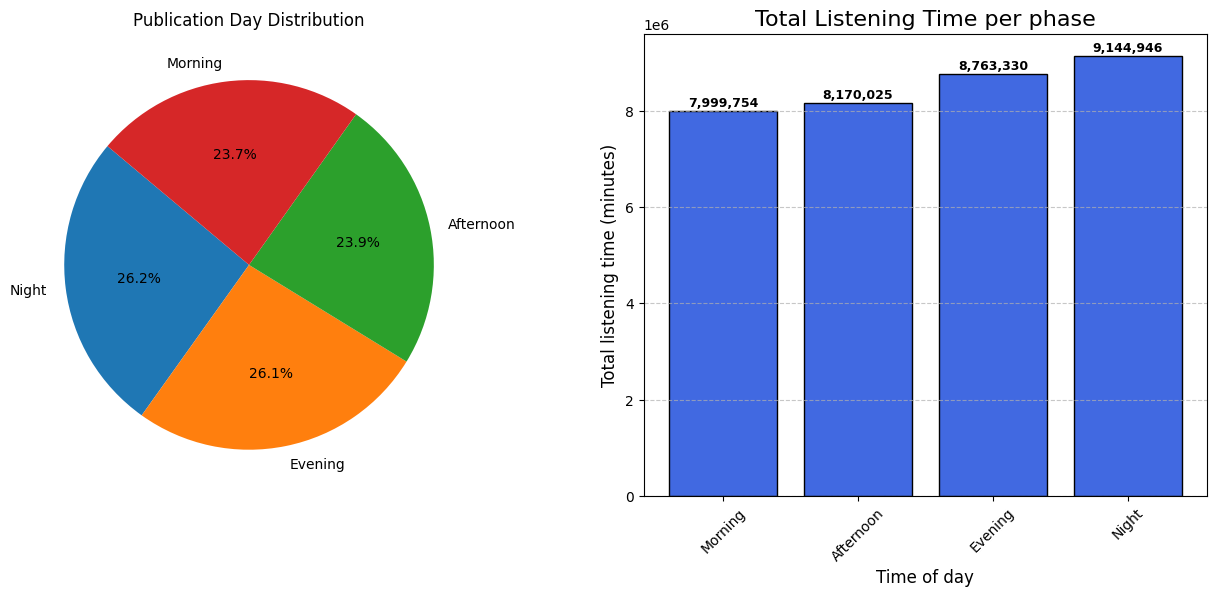

In [26]:
sorted_phases = ['Morning', 'Afternoon', 'Evening', 'Night']
total_watch_time_phase.sort()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

draw_pie(X.Publication_Time, ax=axes[0], title='Publication Day Distribution')
plot_bar(sorted_phases, total_watch_time_phase, ax = axes[1],  title='Total Listening Time per phase', x_label= 'Time of day', y_label='Total listening time (minutes)')

We can clearly see a increase in listening time as the day progresses, as people head back to thier houses after work, college or schools.

In [27]:
total_watch_time_genre = []
genres = []

for i, genre in enumerate(X.Genre.unique()):
    watch_time = trainData[trainData["Genre"] == genre].Listening_Time_minutes.sum()
    genres.append(genre)
    total_watch_time_genre.append(watch_time)

print(genres)
print(total_watch_time_genre)

['True Crime', 'Comedy', 'Education', 'Technology', 'Health', 'News', 'Music', 'Sports', 'Business', 'Lifestyle']
[np.float64(3916329.57799), np.float64(3618666.8585200002), np.float64(2245669.01855), np.float64(3936270.8953099996), np.float64(3266668.7298800005), np.float64(2814683.4474500003), np.float64(2922468.14842), np.float64(3936638.86794), np.float64(3666777.4350699997), np.float64(3753881.73697)]


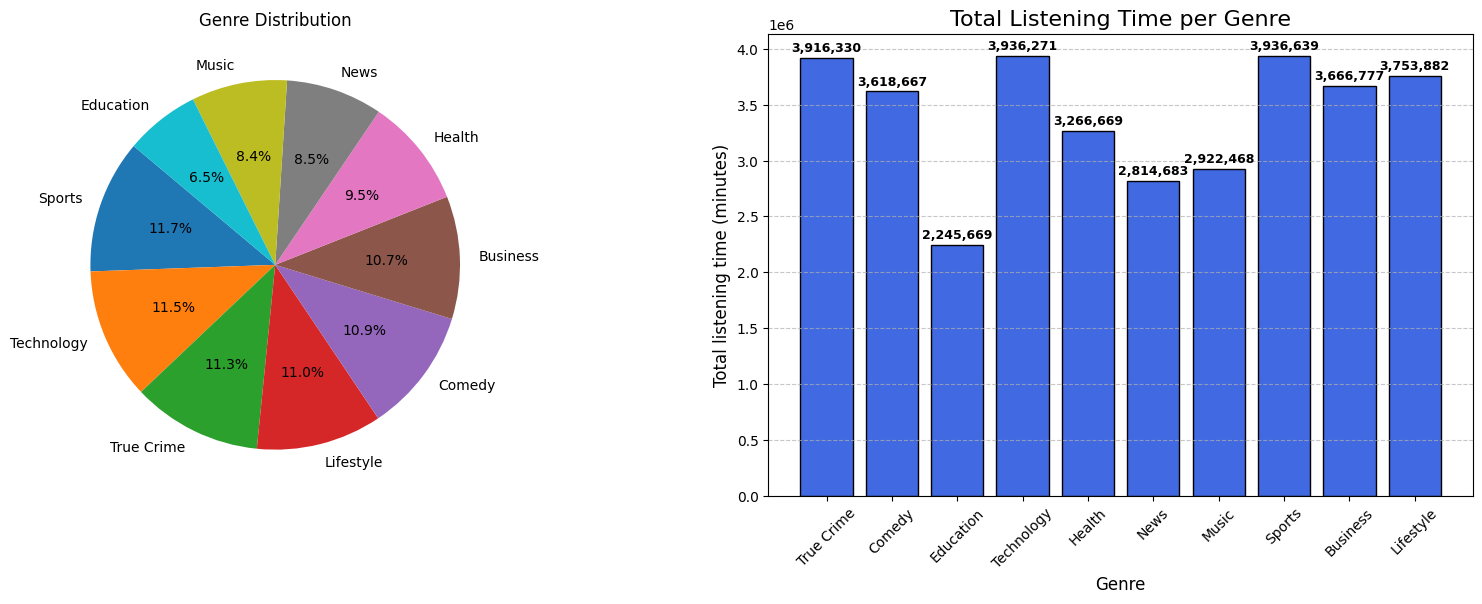

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

draw_pie(X.Genre, ax=axes[0], title='Genre Distribution')
plot_bar(genres, total_watch_time_genre,  title='Total Listening Time per Genre', x_label= 'Genre', y_label='Total listening time (minutes)', ax = axes[1])

Outliers:
        Number_of_Ads
211159          53.37
283606         103.91
436577         103.00
495919          53.42
537705         103.75
567235          12.00
602553         103.25
672139         103.25
683147         103.88


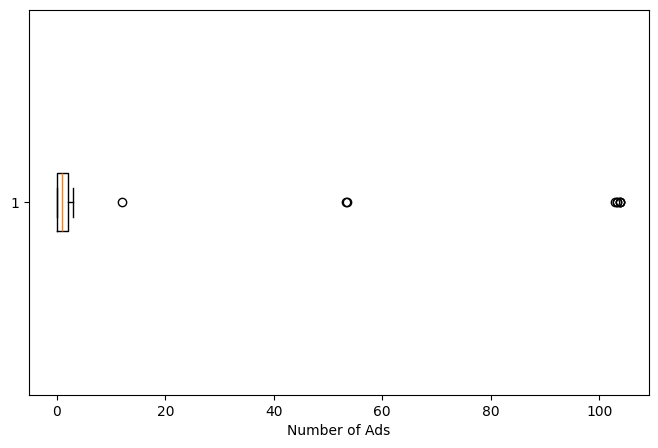

In [29]:
outliers(X, 'Number_of_Ads')
plt.figure(figsize=(8, 5))
plt.boxplot(X.Number_of_Ads.dropna(), vert=False)
plt.xlabel('Number of Ads')
plt.show()

In [30]:
print(f'Max Host Popularity: {X.Host_Popularity_percentage.max()}\nMin Host Popularity: {X.Host_Popularity_percentage.min()}')
print(f'Max Guest Popularity: {X.Guest_Popularity_percentage.max()}\nMin Guest Popularity: {X.Guest_Popularity_percentage.min()}')

Max Host Popularity: 119.46
Min Host Popularity: 1.3
Max Guest Popularity: 119.91
Min Guest Popularity: 0.0


Outliers:
Empty DataFrame
Columns: [Host_Popularity_percentage]
Index: []


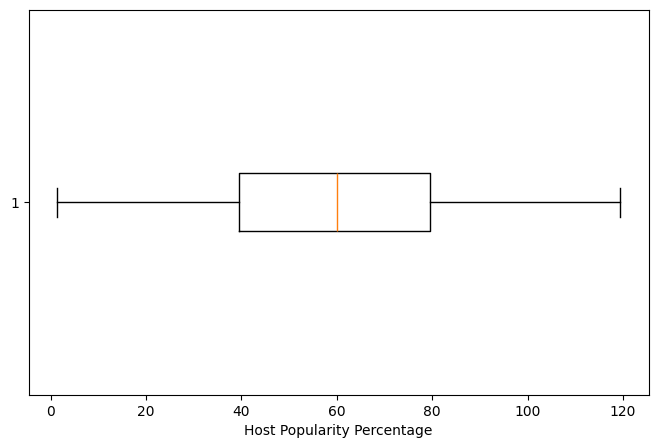

In [31]:
outliers(X, 'Host_Popularity_percentage')
plt.figure(figsize=(8, 5))
plt.boxplot(X.Host_Popularity_percentage.dropna(), vert=False)
plt.xlabel('Host Popularity Percentage')
plt.show()

Outliers:
Empty DataFrame
Columns: [Guest_Popularity_percentage]
Index: []


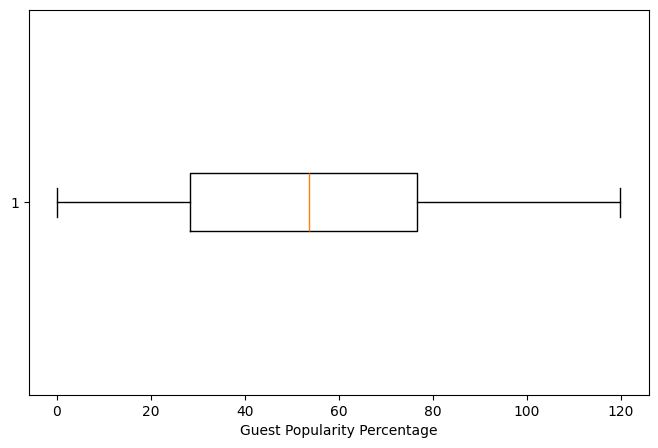

In [32]:
outliers(X, 'Guest_Popularity_percentage')
plt.figure(figsize=(8, 5))
plt.boxplot(X.Guest_Popularity_percentage.dropna(), vert=False)
plt.xlabel('Guest Popularity Percentage')
plt.show()

In [33]:
X

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative


## **Pipelines**

In [34]:
def weekend(df_in):
    df = df_in.copy()
    df['Is_Weekend'] = df['Publication_Day'].isin(['Saturday', 'Sunday'])

    return df

def truncate(df_in):
    df = df_in.copy()
    df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].clip(lower=0, upper=99)
    df['Host_Popularity_percentage'] = df['Host_Popularity_percentage'].clip(lower=0, upper=99)
    df['Number_of_Ads'] = df['Number_of_Ads'].clip(lower=0, upper=4)

    return df

def popularity(df_in):
    df = df_in.copy()
    
    def get_popularity_label(pct):
        if pct >= 80:
            return "Very Popular"
        elif pct >= 55:
            return "Popular"
        elif pct >= 15:
            return "Not Popular"
        else:
            return "New"

    df['Guest_Popularity_Level'] = df['Guest_Popularity_percentage'].apply(get_popularity_label)
    df['Host_Popularity_Level'] = df['Host_Popularity_percentage'].apply(get_popularity_label)

    return df

def compute_episode_popularity(df_in):
    df = df_in.copy()
    
    time_scores = {'Night': 4, 'Evening': 3, 'Afternoon': 2, 'morning': 1}
    day_scores = {
        'Sunday': 7, 'Monday': 6, 'Wednesday': 5, 
        'Friday': 4, 'Saturday': 3, 'Thrusday': 2, 'Tuesday': 1
    }
    sentiment_scores = {'Positive': 3, 'Neutral': 2, 'Negative': 1}
    
    df['Guest_Score'] = df['Guest_Popularity_percentage'] / 100
    df['Host_Score'] = df['Host_Popularity_percentage'] / 100
    df['Time_Score'] = df['Publication_Time'].map(time_scores)
    df['Day_Score'] = df['Publication_Day'].map(day_scores)
    df['Sentiment_Score'] = df['Episode_Sentiment'].map(sentiment_scores)

    df['Episode_Popularity_Score'] = (
        0.3 * df['Guest_Score'] +
        0.3 * df['Host_Score'] +
        0.15 * df['Time_Score'] +
        0.15 * df['Day_Score'] +
        0.1 * df['Sentiment_Score']
    )

    return df


In [35]:
imputer_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [36]:
categorical_columns = X.select_dtypes(include=['object','category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

categorical_columns = categorical_columns.drop('Episode_Title')

categorical_columns_featured = categorical_columns.append(pd.Index(['Guest_Popularity_Level', 'Host_Popularity_Level', 'Is_Weekend']))
numerical_columns_featured = numerical_columns.append(pd.Index(['Guest_Score', 'Host_Score', 'Time_Score', 'Day_Score', 'Sentiment_Score', 'Episode_Popularity_Score']))

imputer = ColumnTransformer(
    transformers=[
        ('num', imputer_transformer, numerical_columns)
], remainder='passthrough', sparse_threshold=0, verbose_feature_names_out=False).set_output(transform='pandas')

preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, numerical_columns_featured),
    ('categorical', categorical_transformer, categorical_columns_featured)
], remainder='passthrough', sparse_threshold=0)

In [37]:
categorical_columns_featured

Index(['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time',
       'Episode_Sentiment', 'Guest_Popularity_Level', 'Host_Popularity_Level',
       'Is_Weekend'],
      dtype='object')

In [38]:
pipeline = Pipeline([
    ('impute', imputer),
    ('truncate', FunctionTransformer(truncate)),
    ('Addfeature1', FunctionTransformer(weekend)),
    ('Addfeature2', FunctionTransformer(popularity)),
    ('Addfeature3', FunctionTransformer(compute_episode_popularity)),
    ('preprocessor', preprocessor)
])

In [39]:
Xtransfrom = pipeline.fit_transform(X)

In [40]:
Xtransfrom = Xtransfrom[:,:-1]

In [41]:
Y_mean = Y.mean()
Y_std = Y.std()

Y_normalized = (Y - Y_mean) / Y_std

In [42]:
Y_normalized.values

array([-0.5165181 ,  1.56881583, -0.01886987, ..., -1.11198564,
        2.03741472, -1.23416018])

In [43]:
x_train, x_val, y_train, y_val = train_test_split(Xtransfrom, Y_normalized.values, test_size=0.2, random_state=69)

In [44]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(600000, 93)
(600000,)
(150000, 93)
(150000,)


In [45]:
linear = LinearRegression()

linear.fit(x_train, y_train)

LinearRegression()

In [46]:
val_predictions_lr = linear.predict(x_val)

print(mse(y_val, val_predictions_lr))
print(r2(y_val, val_predictions_lr))

0.24176680090449162
0.7585414506500563


In [ ]:
xgb = XGBRegressor(tree_method='gpu_hist', objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'colsample_bytree': [0.8, 1],
    'reg_lambda': [1, 10],
    'reg_alpha': [0, 1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3)

grid_search.fit(Xtransfrom, Y_normalized)

In [51]:
print(grid_search.best_params_)
xgb = grid_search.best_estimator_

{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 10}


In [ ]:
val_predictions_xgb = xgb.predict(x_val)

In [ ]:
print(mse(y_val, val_predictions_xgb))
print(r2(y_val, val_predictions_xgb))

0.21910556610177825
0.7811737924830576


In [47]:
x_test = pipeline.transform(testData)

In [48]:
x_test = x_test[:, :-1]
x_test.shape

(250000, 93)

In [ ]:
predictions_xgb = xgb.predict(x_test)
predictions_xgb = predictions_xgb*Y_std + Y_mean
submission_XGB = testData[['id']].copy()

submission_XGB['Listening_Time_minutes'] = predictions_xgb
submission_XGB.to_csv('SubmissionXGB.csv', index=False)

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'r2_score'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

In [51]:
print(x_train.dtype, y_train.dtype)

x_train = np.array(x_train).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)

x_val = np.array(x_val).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)


train_tensor = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(256).prefetch(tf.data.AUTOTUNE)
val_tensor = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(256).prefetch(tf.data.AUTOTUNE)

object float64


In [52]:
history= model.fit(train_tensor.repeat(),
                   validation_data=val_tensor.repeat(),
                   epochs=100,
                   steps_per_epoch=500,
                   validation_steps=100,
                   callbacks=[early_stop])

Epoch 1/100


500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1.5053 - mse: 1.5053 - r2_score: -0.4950 - val_loss: 0.4430 - val_mse: 0.4430 - val_r2_score: 0.5561
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.9217 - mse: 0.9217 - r2_score: 0.0769 - val_loss: 0.3749 - val_mse: 0.3749 - val_r2_score: 0.6243
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.7516 - mse: 0.7516 - r2_score: 0.2474 - val_loss: 0.3503 - val_mse: 0.3503 - val_r2_score: 0.6490
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.6526 - mse: 0.6526 - r2_score: 0.3446 - val_loss: 0.3339 - val_mse: 0.3339 - val_r2_score: 0.6654
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5825 - mse: 0.5825 - r2_score: 0.4179 - val_loss: 0.3211 - val_mse: 0.3211 - val_r2_score: 0.6783
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5302 - mse: 0.5302 - r2_score: 0.4665 - val_loss: 0.3125 - val_mse: 0.3125 - val_r2_score: 0.6869
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 1

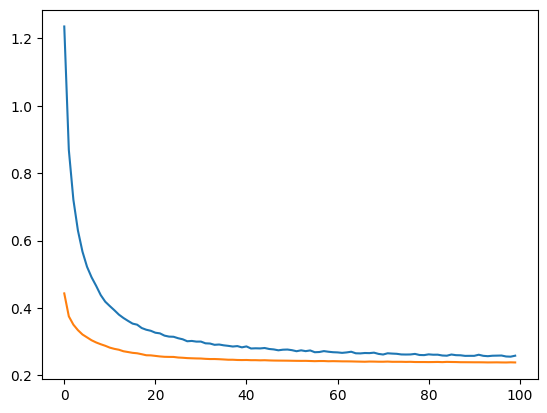

In [53]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

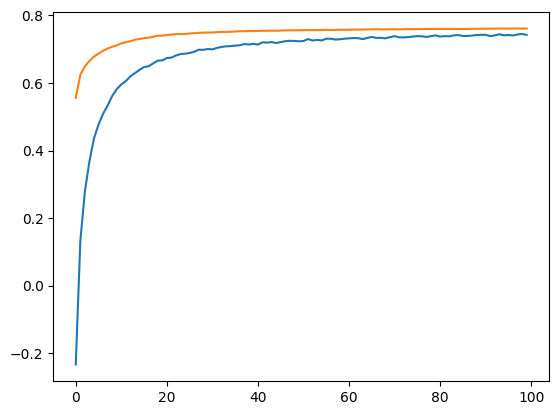

In [54]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])

In [55]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

model2.compile(loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'r2_score'],
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))

early_stop = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')

In [56]:
history2 = model2.fit(train_tensor.repeat(),
                   validation_data=val_tensor.repeat(),
                   epochs=100,
                   steps_per_epoch=500,
                   validation_steps=100,
                   callbacks=[early_stop])

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 3.0846 - mse: 3.0846 - r2_score: -2.0638 - val_loss: 0.7233 - val_mse: 0.7233 - val_r2_score: 0.2752
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.9925 - mse: 1.9925 - r2_score: -0.9953 - val_loss: 0.5799 - val_mse: 0.5799 - val_r2_score: 0.4190
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.7440 - mse: 1.7440 - r2_score: -0.7464 - val_loss: 0.5028 - val_mse: 0.5028 - val_r2_score: 0.4962
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5615 - mse: 1.5615 - r2_score: -0.5681 - val_loss: 0.4600 - val_mse: 0.4600 - val_r2_score: 0.5391
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4499 - mse: 1.4499 - r2_score: -0.4490 - val_loss: 0.4305 - val_mse: 0.4305 - val_r2_score: 0.5687
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.3370 - mse: 1.3370 - r2_score: -0.3452 - val_loss: 0.4045 - val_mse: 0.4045 - val_r2_score: 0.5947
Epoch 7/100
500/500 ━━━━━━━━

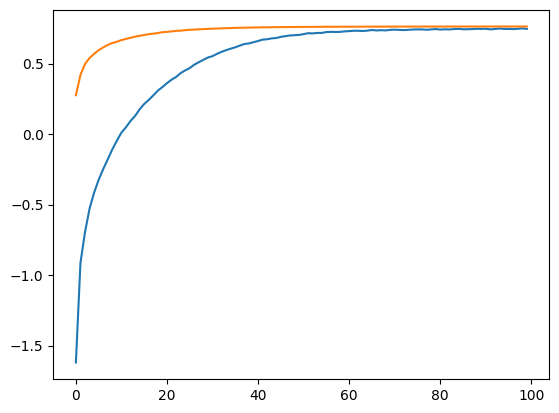

In [57]:
plt.plot(history2.history['r2_score'])
plt.plot(history2.history['val_r2_score'])

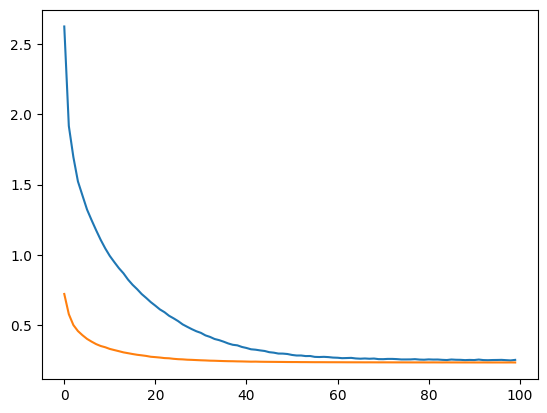

In [58]:
plt.plot(history2.history['mse'])
plt.plot(history2.history['val_mse'])

In [59]:
stack1 = model.predict(x_val)
stack2 = model2.predict(x_val)

stackData = np.column_stack((stack1, stack2))

4688/4688 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 664us/step


In [60]:
x_stack_train, x_stack_val, y_stack_train, y_stack_val = train_test_split(stackData, y_val, test_size=0.2, random_state=12)

In [61]:
lr2 = LinearRegression()

lr2.fit(x_stack_train, y_stack_train)

LinearRegression()

In [62]:
val_predictions_lr_stack = lr2.predict(x_stack_val)

print(mse(y_stack_val, val_predictions_lr_stack))
print(r2(y_stack_val, val_predictions_lr_stack))

0.2427174
0.758301854133606


In [ ]:
xgb = XGBRegressor(tree_method='hist', device='cuda', objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [50, 150],
    'max_depth': [4, 6, 8],
    'learning_rate': [1e-3, 1e-2, 1e-1]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3)

grid_search.fit(x_stack_train, y_stack_train)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [18:17:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=No...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [4, 6, 8], 'n_estimators': [50, 150]},
             scoring='neg_mean_squared_error')

In [64]:
print(grid_search.best_params_)
xg_stack = grid_search.best_estimator_
val_predictions_xgb_stack = xg_stack.predict(x_stack_val)

print(mse(y_stack_val, val_predictions_xgb_stack))
print(r2(y_stack_val, val_predictions_xgb_stack))

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}
0.2422888
0.7587286233901978


In [67]:
import optuna

def create_model(trial):
    model = tf.keras.Sequential()
    n_layers = trial.suggest_int('n_layers', 1, 3)
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 32, 512, step=32)
        model.add(tf.keras.layers.Dense(num_hidden, activation='relu'))
        
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.0, 0.5)
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(1))  

    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='mse', optimizer=optimizer)
    return model


def objective(trial):
    model = create_model(trial)
    
    history = model.fit(
        train_tensor,
        validation_data=val_tensor,
        epochs=50,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    )

    y_pred = model.predict(x_val).flatten()
    return mse(y_val, y_pred)


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Value (MSE):", trial.value)
print("  Params:", trial.params)

[I 2025-04-25 18:40:27,119] A new study created in memory with name: no-name-311c1af9-1128-4f76-a8b0-9004a831a706


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 574us/step


[I 2025-04-25 18:41:49,082] Trial 0 finished with value: 0.23928460478782654 and parameters: {'n_layers': 1, 'n_units_l0': 256, 'dropout_l0': 0.09162884902844426, 'lr': 0.0008558522847471393}. Best is trial 0 with value: 0.23928460478782654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 606us/step


[I 2025-04-25 18:46:17,145] Trial 1 finished with value: 0.23736830055713654 and parameters: {'n_layers': 2, 'n_units_l0': 512, 'dropout_l0': 0.32182803059259735, 'n_units_l1': 96, 'dropout_l1': 0.34726430621488613, 'lr': 3.7852481683217824e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 536us/step


[I 2025-04-25 18:47:50,089] Trial 2 finished with value: 0.24561744928359985 and parameters: {'n_layers': 2, 'n_units_l0': 192, 'dropout_l0': 0.2088998065020432, 'n_units_l1': 64, 'dropout_l1': 0.20303203784877116, 'lr': 0.005067723291645598}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 530us/step


[I 2025-04-25 18:49:40,416] Trial 3 finished with value: 0.23828378319740295 and parameters: {'n_layers': 1, 'n_units_l0': 448, 'dropout_l0': 0.09587807861620828, 'lr': 0.00010072531561449562}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 584us/step


[I 2025-04-25 18:50:19,097] Trial 4 finished with value: 0.5027651786804199 and parameters: {'n_layers': 3, 'n_units_l0': 320, 'dropout_l0': 0.2960480740891293, 'n_units_l1': 64, 'dropout_l1': 0.47074848779048917, 'n_units_l2': 192, 'dropout_l2': 0.11515664543474952, 'lr': 5.964814666479395e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 629us/step


[I 2025-04-25 18:51:09,660] Trial 5 finished with value: 0.25047680735588074 and parameters: {'n_layers': 2, 'n_units_l0': 480, 'dropout_l0': 0.37269166458138137, 'n_units_l1': 224, 'dropout_l1': 0.12361412267190991, 'lr': 1.5752603543504627e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 612us/step


[I 2025-04-25 18:51:49,967] Trial 6 finished with value: 0.24394719302654266 and parameters: {'n_layers': 2, 'n_units_l0': 352, 'dropout_l0': 0.06869083740897486, 'n_units_l1': 288, 'dropout_l1': 0.09927231635781014, 'lr': 0.003677543930381617}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 533us/step


[I 2025-04-25 18:55:15,086] Trial 7 finished with value: 0.2399550825357437 and parameters: {'n_layers': 2, 'n_units_l0': 160, 'dropout_l0': 0.11672493644793142, 'n_units_l1': 128, 'dropout_l1': 0.18047081958784156, 'lr': 1.3215248821078994e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 2s 519us/step


[I 2025-04-25 18:55:44,399] Trial 8 finished with value: 0.26009508967399597 and parameters: {'n_layers': 2, 'n_units_l0': 64, 'dropout_l0': 0.38893315956704383, 'n_units_l1': 64, 'dropout_l1': 0.3477386446807102, 'lr': 0.00019190578324232245}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 615us/step


[I 2025-04-25 18:56:51,027] Trial 9 finished with value: 0.2475854903459549 and parameters: {'n_layers': 3, 'n_units_l0': 160, 'dropout_l0': 0.11482648254054584, 'n_units_l1': 192, 'dropout_l1': 0.13664785915154282, 'n_units_l2': 352, 'dropout_l2': 0.16920508355392416, 'lr': 1.6301153353364714e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 4s 885us/step


[I 2025-04-25 18:59:34,253] Trial 10 finished with value: 0.2505064308643341 and parameters: {'n_layers': 3, 'n_units_l0': 512, 'dropout_l0': 0.4994321918775427, 'n_units_l1': 480, 'dropout_l1': 0.3426417931476733, 'n_units_l2': 512, 'dropout_l2': 0.4796605543225277, 'lr': 0.0004421592359812365}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 534us/step


[I 2025-04-25 19:02:47,140] Trial 11 finished with value: 0.23780377209186554 and parameters: {'n_layers': 1, 'n_units_l0': 416, 'dropout_l0': 0.21511185613869482, 'lr': 7.121504083218755e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 542us/step


[I 2025-04-25 19:05:59,732] Trial 12 finished with value: 0.23783431947231293 and parameters: {'n_layers': 1, 'n_units_l0': 416, 'dropout_l0': 0.2569493115525741, 'lr': 4.915144807820868e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 2s 524us/step


[I 2025-04-25 19:09:07,567] Trial 13 finished with value: 0.23794911801815033 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout_l0': 0.19679708275715962, 'lr': 4.446980876736199e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 545us/step


[I 2025-04-25 19:11:27,962] Trial 14 finished with value: 0.2378290593624115 and parameters: {'n_layers': 1, 'n_units_l0': 512, 'dropout_l0': 0.33381746443783716, 'lr': 0.00018216572739801956}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 2s 527us/step


[I 2025-04-25 19:13:19,863] Trial 15 finished with value: 0.23894411325454712 and parameters: {'n_layers': 1, 'n_units_l0': 416, 'dropout_l0': 0.4525259198541831, 'lr': 0.0007458843502711013}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 609us/step


[I 2025-04-25 19:14:07,497] Trial 16 finished with value: 0.24381285905838013 and parameters: {'n_layers': 2, 'n_units_l0': 288, 'dropout_l0': 0.18521378557836504, 'n_units_l1': 352, 'dropout_l1': 0.32292029905231523, 'lr': 3.2199071967349704e-05}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step


[I 2025-04-25 19:15:30,866] Trial 17 finished with value: 0.24100536108016968 and parameters: {'n_layers': 3, 'n_units_l0': 480, 'dropout_l0': 0.01343275624319945, 'n_units_l1': 384, 'dropout_l1': 0.42542264932613616, 'n_units_l2': 32, 'dropout_l2': 0.4039687206900184, 'lr': 0.00010920582255228876}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 533us/step


[I 2025-04-25 19:16:18,635] Trial 18 finished with value: 0.2398257553577423 and parameters: {'n_layers': 1, 'n_units_l0': 384, 'dropout_l0': 0.272771812443106, 'lr': 0.0018069825950182202}. Best is trial 1 with value: 0.23736830055713654.


4688/4688 ━━━━━━━━━━━━━━━━━━━━ 3s 612us/step


[I 2025-04-25 19:17:00,401] Trial 19 finished with value: 0.2489667683839798 and parameters: {'n_layers': 2, 'n_units_l0': 448, 'dropout_l0': 0.32350564249191127, 'n_units_l1': 192, 'dropout_l1': 0.26068478636487896, 'lr': 2.52268759870817e-05}. Best is trial 1 with value: 0.23736830055713654.


Best trial:
  Value (MSE): 0.23736830055713654
  Params: {'n_layers': 2, 'n_units_l0': 512, 'dropout_l0': 0.32182803059259735, 'n_units_l1': 96, 'dropout_l1': 0.34726430621488613, 'lr': 3.7852481683217824e-05}


In [70]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.32182803059259735),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.34726430621488613),
    tf.keras.layers.Dense(1)
])

model3.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=3.7852481683217824e-05),
              metrics=['mse', 'r2_score'])

In [72]:
model3.fit(train_tensor.repeat(),
            validation_data=val_tensor.repeat(),
            epochs=100,
            steps_per_epoch=500,
            validation_steps=100,
            callbacks=[early_stop])

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2637 - mse: 0.2637 - r2_score: 0.7380 - val_loss: 0.2450 - val_mse: 0.2450 - val_r2_score: 0.7545
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2650 - mse: 0.2650 - r2_score: 0.7347 - val_loss: 0.2443 - val_mse: 0.2443 - val_r2_score: 0.7552
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2677 - mse: 0.2677 - r2_score: 0.7320 - val_loss: 0.2422 - val_mse: 0.2422 - val_r2_score: 0.7574
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2627 - mse: 0.2627 - r2_score: 0.7362 - val_loss: 0.2428 - val_mse: 0.2428 - val_r2_score: 0.7567
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2607 - mse: 0.2607 - r2_score: 0.7394 - val_loss: 0.2418 - val_mse: 0.2418 - val_r2_score: 0.7578
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2573 - mse: 0.2573 - r2_score: 0.7411 - val_loss: 0.2422 - val_mse: 0.2422 - val_r2_score: 0.7573
Epoch 7/100
500/500 ━━━━━━━━━━━━━━

In [81]:
categorical_columns_titled = categorical_columns.append(pd.Index(['Episode_Title']))

preprocessor_no_feature = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('categorical', categorical_transformer, categorical_columns_titled)
], remainder='passthrough', sparse_threshold=0)

pipeline_no_feature = Pipeline([
    ('preprocessor', preprocessor_no_feature)
])

X_no_feature = pipeline_no_feature.fit_transform(X)

In [82]:
x_no_feature_train, x_no_feature_val, y_no_feature_train, y_no_feature_val = train_test_split(X_no_feature, Y_normalized.values, test_size=0.2, random_state=12)

In [83]:
print(x_no_feature_train.shape)
print(y_no_feature_train.shape)

(600000, 177)
(600000,)


In [84]:
print(x_no_feature_train.dtype, y_no_feature_train.dtype)

x_no_feature_train = np.array(x_no_feature_train).astype(np.float32)
y_no_feature_train = np.array(y_no_feature_train).astype(np.float32)

x_no_feature_val = np.array(x_no_feature_val).astype(np.float32)
y_no_feature_val = np.array(y_no_feature_val).astype(np.float32)


train_no_feature_tensor = tf.data.Dataset.from_tensor_slices((x_no_feature_train, y_no_feature_train)).batch(256).prefetch(tf.data.AUTOTUNE)
val_no_feature_tensor = tf.data.Dataset.from_tensor_slices((x_no_feature_val, y_no_feature_val)).batch(256).prefetch(tf.data.AUTOTUNE)

float64 float64


In [101]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.32182803059259735),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dropout(0.34726430621488613),
    tf.keras.layers.Dense(1)
])

model4.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=3.7852481683217824e-05),
              metrics=['mse', 'r2_score'])

model4.fit(train_no_feature_tensor.repeat(),
            validation_data=val_no_feature_tensor.repeat(),
            epochs=100,
            steps_per_epoch=500,
            validation_steps=100)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6401 - mse: 0.6401 - r2_score: 0.3638 - val_loss: 0.2435 - val_mse: 0.2435 - val_r2_score: 0.7559
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3093 - mse: 0.3093 - r2_score: 0.6900 - val_loss: 0.2398 - val_mse: 0.2398 - val_r2_score: 0.7597
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2888 - mse: 0.2888 - r2_score: 0.7109 - val_loss: 0.2389 - val_mse: 0.2389 - val_r2_score: 0.7606
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2815 - mse: 0.2815 - r2_score: 0.7192 - val_loss: 0.2382 - val_mse: 0.2382 - val_r2_score: 0.7612
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2748 - mse: 0.2748 - r2_score: 0.7251 - val_loss: 0.2378 - val_mse: 0.2378 - val_r2_score: 0.7617
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2690 - mse: 0.2690 - r2_score: 0.7312 - val_loss: 0.2382 - val_mse: 0.2382 - val_r2_score: 0.7613
Epoch 7/100
500/500 ━━━━━━━━━━━━━━

In [102]:
x_test_no_feature = pipeline_no_feature.transform(testData)

predictions_model4 = model4.predict(np.array(x_test_no_feature).astype(np.float32))
predictions_model4 = predictions_model4*Y_std + Y_mean
submission_model4 = testData[['id']].copy()

submission_model4['Listening_Time_minutes'] = predictions_model4
submission_model4['Listening_Time_minutes'] = submission_model4['Listening_Time_minutes'].clip(lower=0, upper=120)

submission_model4.to_csv(r'submissions/SubmissionNN.csv', index=False)

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 6s 702us/step


In [103]:
print(submission_model4.Listening_Time_minutes.max())
print(trainData.Listening_Time_minutes.max())

120.0
119.97


### **Stacking Classifier**

In [ ]:
def layered_stacking_regressor(X, y):
    layer1_models = [
        XGBRegressor(tree_method='hist', device='cuda'), 
        XGBRegressor(tree_method='hist', device='cuda', n_estimators=50),
        MLPRegressor(hidden_layer_sizes=(64,), max_iter=500),
        MLPRegressor(hidden_layer_sizes=(32,), max_iter=500),
        XGBRegressor(tree_method='hist', device='cuda', max_depth=4),
        MLPRegressor(hidden_layer_sizes=(128,), max_iter=500),
        XGBRegressor(tree_method='hist', device='cuda', learning_rate=0.05)
    ]
    layer1_out = np.column_stack([
        cross_val_predict(clone(model), X, y, cv=3, method='predict')
        for model in layer1_models
    ])

    layer2_models = [
        RandomForestRegressor(n_estimators=100),
        SVR(),
        RandomForestRegressor(n_estimators=50, max_depth=6),
        SVR(C=0.5),
        RandomForestRegressor(n_estimators=70, max_depth=8)
    ]
    layer2_out = np.column_stack([
        cross_val_predict(clone(model), layer1_out, y, cv=3, method='predict')
        for model in layer2_models
    ])

    layer3_models = [
        LinearRegression(),
        Ridge(),
        LinearRegression()
    ]
    layer3_out = np.column_stack([
        cross_val_predict(clone(model), layer2_out, y, cv=3, method='predict')
        for model in layer3_models
    ])

    final_model = XGBRegressor()
    final_model.fit(layer3_out, y)

    return final_model

In [ ]:
final_model= layered_stacking_regressor(x_train, y_train)